In [2]:
#Setup
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
data = open('higgs_100000_pt_250_500.pkl','rb')
new_dict = pickle.load(data)
data2 = open('qcd_100000_pt_250_500.pkl','rb')
qcd_dict = pickle.load(data2)

In [3]:
high_lumi = pd.read_hdf('data_highLumi_pt_250_500.h5')

In [4]:
low_lumi = pd.read_hdf('data_lowLumi_pt_250_500.h5')

In [5]:
#Random Samples using expected number of events for a given run
state = 123
higgs_events = new_dict.sample(n=100, random_state = state)
qcd_events = qcd_dict.sample(n=20000, random_state = state)

In [6]:
#Making lists of labels
higgs_labels = [1]*100000
qcd_labels = [0]*100000

In [7]:
#Labeling and combining sampled data
new_dict['label'] = higgs_labels
qcd_dict['label'] = qcd_labels
sample = pd.concat([new_dict,qcd_dict])

## **Part 1:** Event Selection Optimization

#### 1) Make a stacked histogram plot for the feature variable: mass

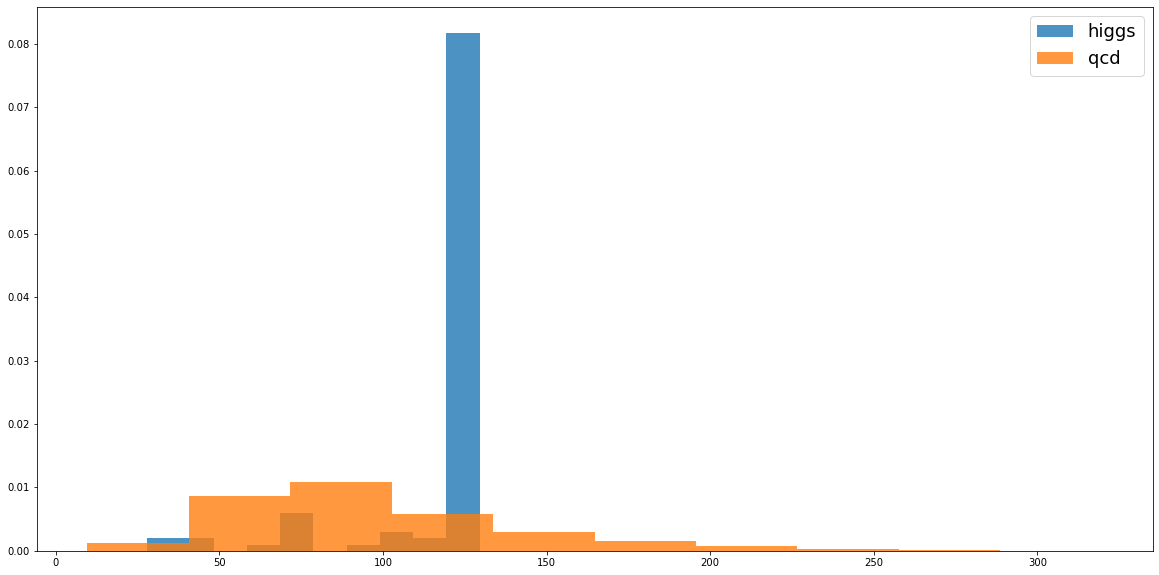

In [8]:
fig, ax = plt.subplots(1,1)
ax.hist(higgs_events['mass'],density = True,alpha = 0.8, label = 'higgs')
ax.hist(qcd_events['mass'],density = True,alpha = 0.8, label = 'qcd')
plt.legend(fontsize = 18)
plt.show()

Expected events in background is 20,000 and is poisson distirbuted

#### $\cdot$ Use Poisson statistics for significance calculation

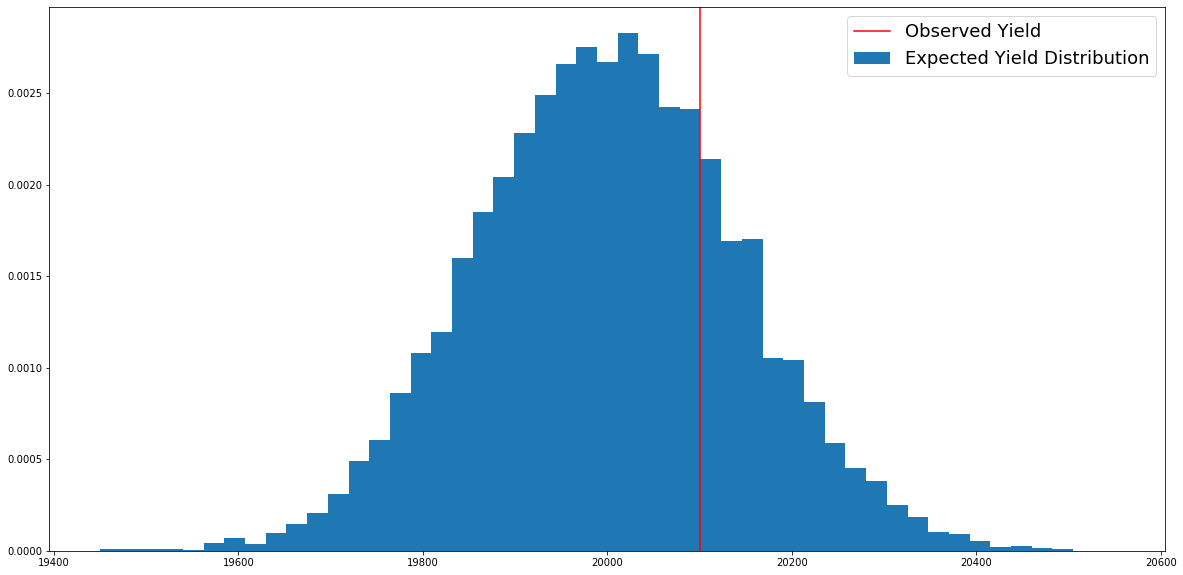

In [9]:
np.random.seed(123)
dist = stats.poisson.rvs(20000, size = 10000)
plt.hist(dist,density = True, bins = np.linspace(19450,20550,50), label = 'Expected Yield Distribution')
plt.axvline(20100,color = 'red',label = 'Observed Yield')
plt.legend(fontsize = 18)
plt.show()

In [10]:
print('Significance of 20100 events:', np.round(stats.norm.isf(stats.poisson.sf(20100,20000)),3),'sigma')

Significance of 20100 events: 0.711 sigma


$\frac{\textbf{N}_{Higgs}}{\sqrt{\textbf{N}_{QCD}}} = \frac{100}{\sqrt{20000}} = 0.707$

This value is different than the value obtained in the previous calculation. This is because the value $\frac{\textbf{N}_{Higgs}}{\sqrt{\textbf{N}_{QCD}}}$ is the number of standard deviations away from the mean the measurment is, while the number from the above calculation is how the probability of the background producing a value larger than the observed value corresponds to the standard normal distributions $\sigma$.

In [11]:
def mult_cut(qcd,higgs,features,cuts):
    '''
    Parameters:
        qcd - qcd data dictionary
        higgs - higgs data dictionary
        features (list) - the features to apply cuts to
        cuts (list of touples) - in format ((min,max),(min,max)) 
    Returns:
        number of qcd and higgs events
        cut min and max
        significance
    '''
    qcd_factor = 20000/len(qcd)
    higgs_factor = 100/len(higgs)
    mu = qcd
    signal = higgs
    for i in range(0,len(features)):
        a = np.array(mu[features[i]])
        b = np.array(signal[features[i]])
        mu = mu[:][np.logical_and(a>cuts[i][0], a<cuts[i][1])]
        signal = signal[:][np.logical_and(b>cuts[i][0], b<cuts[i][1])]
    mu = len(mu)*qcd_factor
    signal = len(signal)*higgs_factor
    sig = np.round(stats.norm.isf(stats.poisson.sf(mu + signal,mu)),3)
    print(features,'cuts', cuts ,'leaves',mu,'expected qcd events and',signal,'expected higgs events')
    print('Significance of', mu+signal ,'events:',sig,'sigma')
    print('---------------------------------------------\n')

#### 2) Identify mass cuts to optimize the expected significance

In [12]:
s = 120
for n in range(0,7):
    mult_cut(qcd_dict,new_dict,['mass'],[(s,150)])
    s+=1

['mass'] cuts [(120, 150)] leaves 2381.6 expected qcd events and 78.065 expected higgs events
Significance of 2459.665 events: 1.591 sigma
---------------------------------------------

['mass'] cuts [(121, 150)] leaves 2262.4 expected qcd events and 77.038 expected higgs events
Significance of 2339.438 events: 1.615 sigma
---------------------------------------------

['mass'] cuts [(122, 150)] leaves 2157.4 expected qcd events and 75.605 expected higgs events
Significance of 2233.005 events: 1.632 sigma
---------------------------------------------

['mass'] cuts [(123, 150)] leaves 2052.6 expected qcd events and 73.643 expected higgs events
Significance of 2126.243 events: 1.625 sigma
---------------------------------------------

['mass'] cuts [(124, 150)] leaves 1953.0 expected qcd events and 70.109 expected higgs events
Significance of 2023.109 events: 1.59 sigma
---------------------------------------------

['mass'] cuts [(125, 150)] leaves 1852.6000000000001 expected qcd event

In [13]:
s = 132
for n in range(0,7):
    mult_cut(qcd_dict,new_dict,['mass'],[(124,s)])
    s-=1

['mass'] cuts [(124, 132)] leaves 724.6 expected qcd events and 69.554 expected higgs events
Significance of 794.154 events: 2.563 sigma
---------------------------------------------

['mass'] cuts [(124, 131)] leaves 640.6 expected qcd events and 68.992 expected higgs events
Significance of 709.592 events: 2.682 sigma
---------------------------------------------

['mass'] cuts [(124, 130)] leaves 551.6 expected qcd events and 67.891 expected higgs events
Significance of 619.491 events: 2.842 sigma
---------------------------------------------

['mass'] cuts [(124, 129)] leaves 469.20000000000005 expected qcd events and 65.21600000000001 expected higgs events
Significance of 534.416 events: 2.956 sigma
---------------------------------------------

['mass'] cuts [(124, 128)] leaves 382.8 expected qcd events and 60.361000000000004 expected higgs events
Significance of 443.161 events: 3.034 sigma
---------------------------------------------

['mass'] cuts [(124, 127)] leaves 291.400000

Cut optimization was performed on the unsampled data in order to not overfit the cuts to the sample selected. The optimal cuts kept data with a mass between 124 and 128, and with those cuts yielded a measurement significance of 3.034 sigma.

#### 3) Make stacked histogram plots for the rest of the features
##### With and without optimal mass cuts

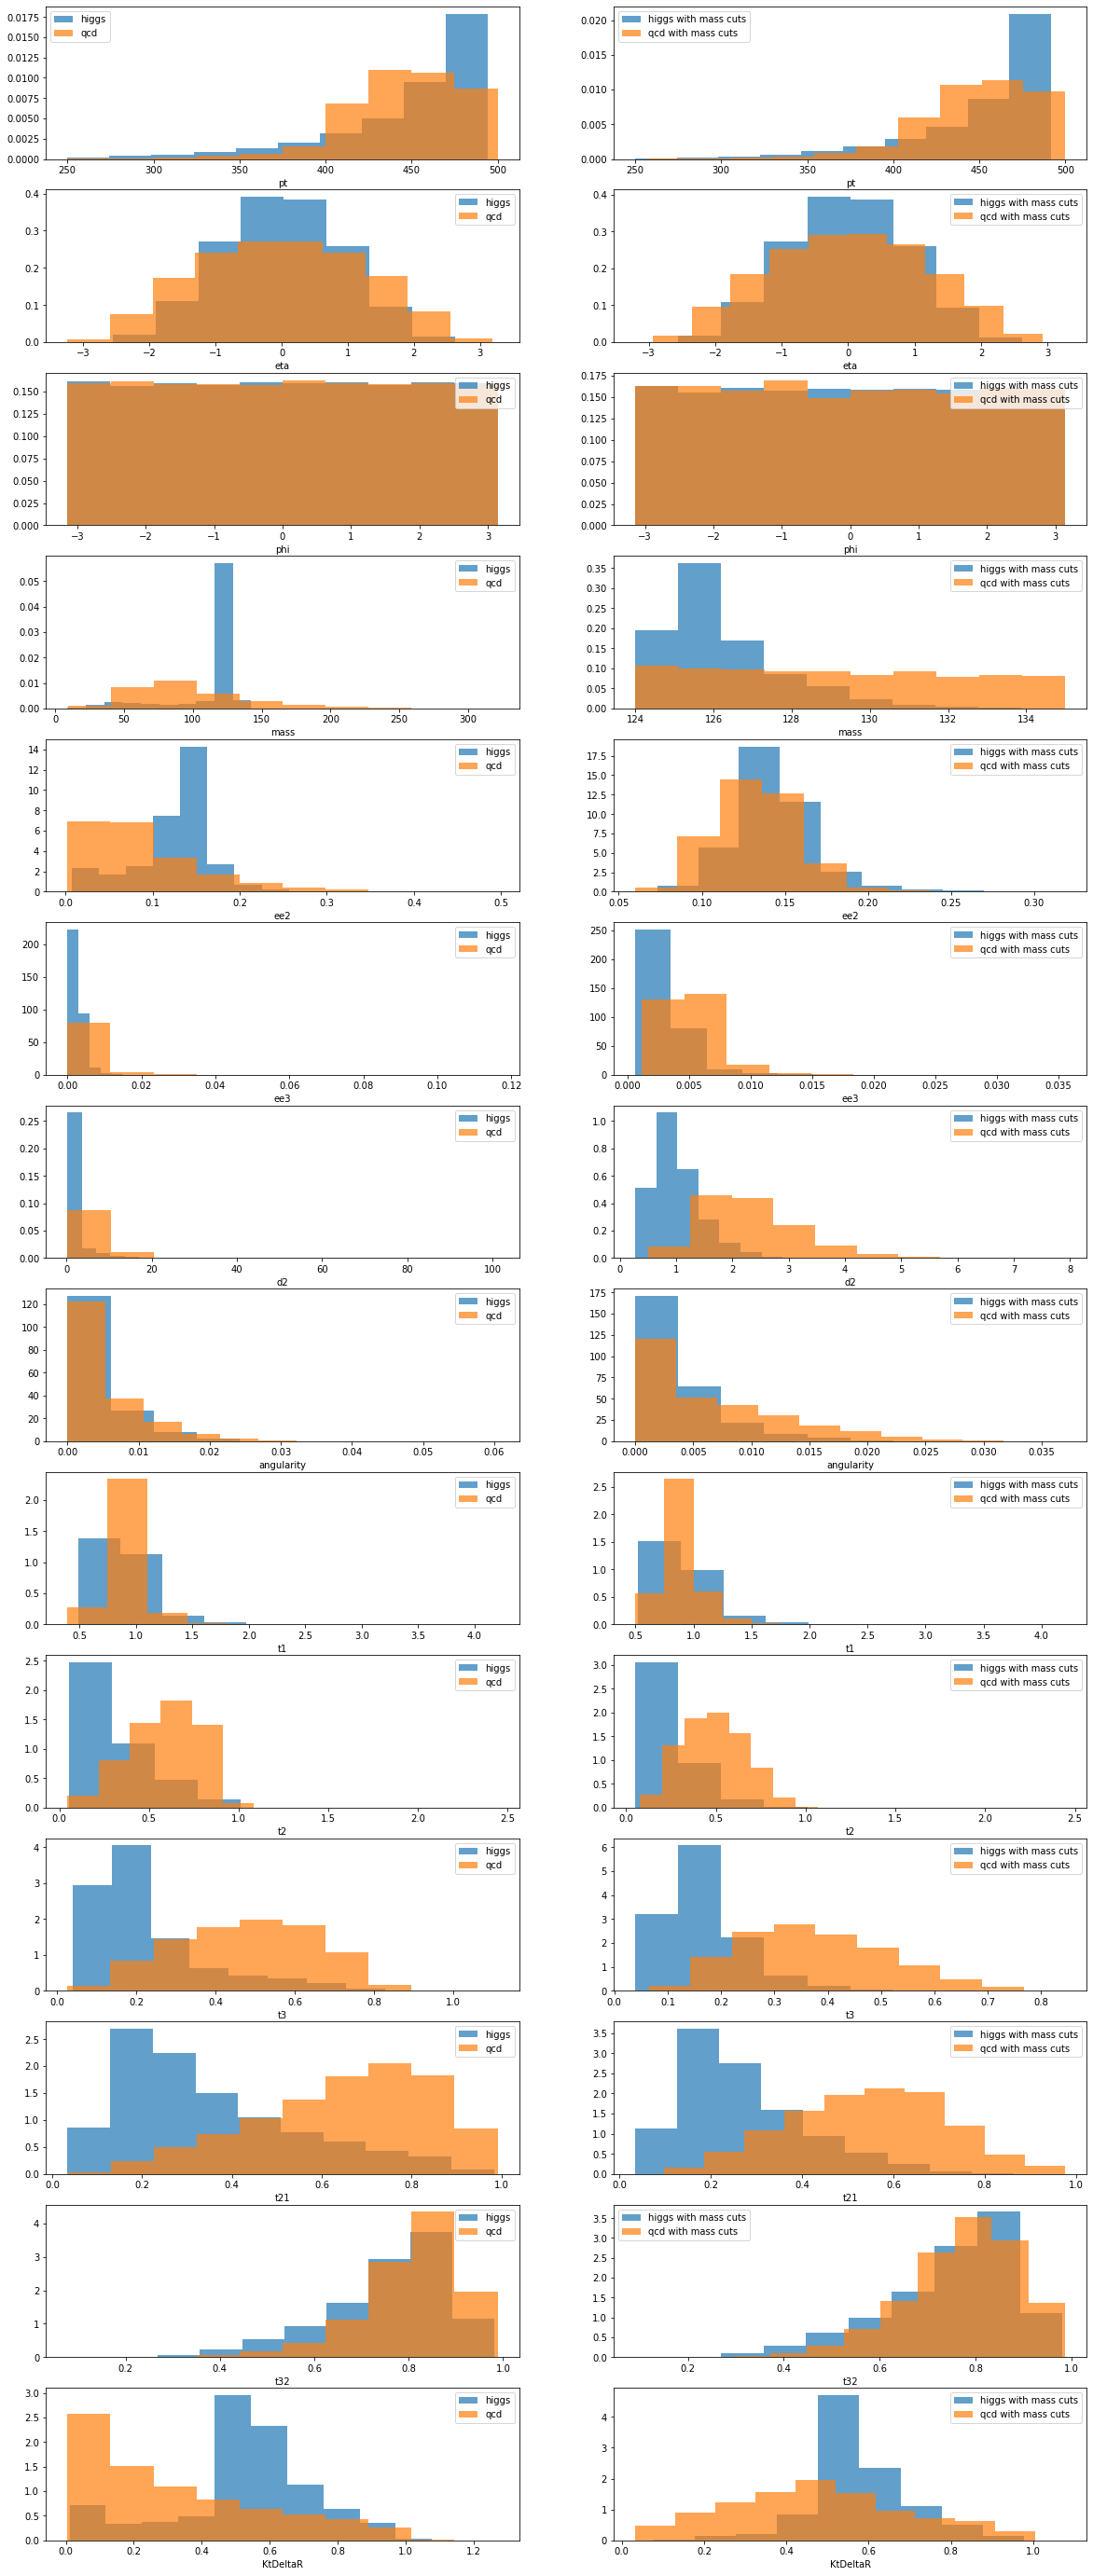

In [14]:
plt.rcParams["figure.figsize"] = (20,50)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12),(ax13,ax14),(ax15,ax16),(ax17,ax18),(ax19,ax20),(ax21,ax22),(ax23,ax24),(ax25,ax26),(ax27,ax28)) = plt.subplots(14,2)
axes = ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12),(ax13,ax14),(ax15,ax16),(ax17,ax18),(ax19,ax20),(ax21,ax22),(ax23,ax24),(ax25,ax26),(ax27,ax28))
labels = ['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']
a = np.array(new_dict['mass'])
b = np.array(qcd_dict['mass'])
for i in range(0,14):
    axes[i][0].hist(new_dict[labels[i]],density = True, alpha = 0.7,label = 'higgs')
    axes[i][0].hist(qcd_dict[labels[i]],density = True, alpha = 0.7,label = 'qcd')
    axes[i][0].set_xlabel(labels[i])
    axes[i][0].legend()
    axes[i][1].hist(new_dict[labels[i]][np.logical_and(a<135, a>124)],density = True, alpha = 0.7,label = 'higgs with mass cuts')
    axes[i][1].hist(qcd_dict[labels[i]][np.logical_and(b<135, b>124)],density = True, alpha = 0.7,label = 'qcd with mass cuts')
    axes[i][1].set_xlabel(labels[i])
    axes[i][1].legend()
plt.show()

#### 4) Optimize event selections using multiple features

In [15]:
mult_cut(qcd_dict,new_dict,['d2'],[(0,1.42)])

['d2'] cuts [(0, 1.42)] leaves 2029.6000000000001 expected qcd events and 64.296 expected higgs events
Significance of 2093.896 events: 1.415 sigma
---------------------------------------------



In [16]:
mult_cut(qcd_dict,new_dict,['t3'],[(0,0.17)])
mult_cut(qcd_dict,new_dict,['KtDeltaR'],[(0.48,0.93)])
mult_cut(qcd_dict,new_dict,['ee2'],[(0.11,0.21)])
mult_cut(qcd_dict,new_dict,['d2'],[(0,1.42)])

['t3'] cuts [(0, 0.17)] leaves 712.6 expected qcd events and 46.548 expected higgs events
Significance of 759.148 events: 1.744 sigma
---------------------------------------------

['KtDeltaR'] cuts [(0.48, 0.93)] leaves 4809.2 expected qcd events and 72.474 expected higgs events
Significance of 4881.674 events: 1.042 sigma
---------------------------------------------

['ee2'] cuts [(0.11, 0.21)] leaves 4373.6 expected qcd events and 73.07300000000001 expected higgs events
Significance of 4446.673000000001 events: 1.102 sigma
---------------------------------------------

['d2'] cuts [(0, 1.42)] leaves 2029.6000000000001 expected qcd events and 64.296 expected higgs events
Significance of 2093.896 events: 1.415 sigma
---------------------------------------------



In [17]:
mult_cut(qcd_events,higgs_events,['mass','d2'],[(124,128),(0,1.42)])
mult_cut(qcd_events,higgs_events,['mass','KtDeltaR'],[(124,128),(0.48,0.93)])
mult_cut(qcd_events,higgs_events,['mass','ee2'],[(124,128),(0.11,0.21)])
mult_cut(qcd_events,higgs_events,['mass','t3'],[(124,128),(0,0.17)])

['mass', 'd2'] cuts [(124, 128), (0, 1.42)] leaves 28.0 expected qcd events and 55.0 expected higgs events
Significance of 83.0 events: 8.48 sigma
---------------------------------------------

['mass', 'KtDeltaR'] cuts [(124, 128), (0.48, 0.93)] leaves 150.0 expected qcd events and 60.0 expected higgs events
Significance of 210.0 events: 4.666 sigma
---------------------------------------------

['mass', 'ee2'] cuts [(124, 128), (0.11, 0.21)] leaves 266.0 expected qcd events and 61.0 expected higgs events
Significance of 327.0 events: 3.648 sigma
---------------------------------------------

['mass', 't3'] cuts [(124, 128), (0, 0.17)] leaves 18.0 expected qcd events and 39.0 expected higgs events
Significance of 57.0 events: 7.418 sigma
---------------------------------------------



In [18]:
mult_cut(qcd_events,higgs_events,['mass','d2','KtDeltaR'],[(124,128),(0,1.42),(0.48,0.93)])

['mass', 'd2', 'KtDeltaR'] cuts [(124, 128), (0, 1.42), (0.48, 0.93)] leaves 18.0 expected qcd events and 51.0 expected higgs events
Significance of 69.0 events: 9.238 sigma
---------------------------------------------



#### 5) Plot 2-dimensional scattering plots between top two most discriminative features

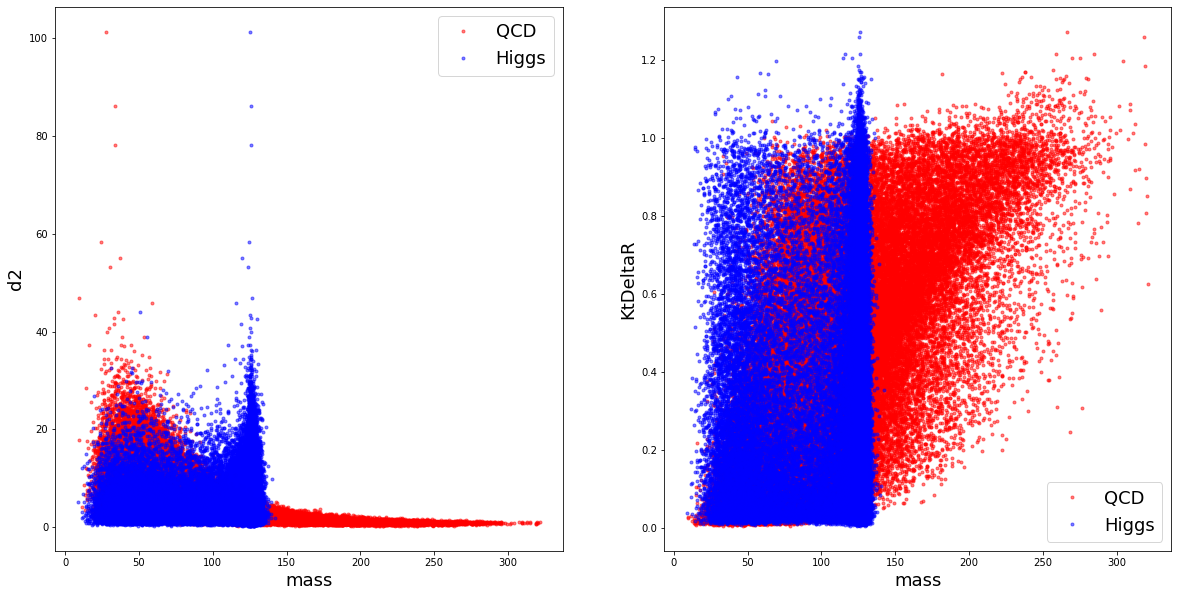

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(qcd_dict['mass'],qcd_dict['d2'],color = 'red', label = 'QCD',ls='',marker='.',alpha=0.5)
ax1.plot(new_dict['mass'],qcd_dict['d2'],color = 'blue',label = 'Higgs',ls='',marker='.',alpha=0.5)
ax1.legend(fontsize = 18)
ax1.set_xlabel('mass',fontsize = 18)
ax1.set_ylabel('d2',fontsize = 18)

ax2.plot(qcd_dict['mass'],qcd_dict['KtDeltaR'],color = 'red', label = 'QCD',ls='',marker='.',alpha=0.5)
ax2.plot(new_dict['mass'],qcd_dict['KtDeltaR'],color = 'blue',label = 'Higgs',ls='',marker='.',alpha=0.5)
ax2.legend(fontsize = 18)
ax2.set_xlabel('mass',fontsize = 18)
ax2.set_ylabel('KtDeltaR',fontsize = 18)
plt.show()

Using Maching Learning to predict

In [20]:
sample_train, sample_test = train_test_split(sample,test_size = 0.2)

X_train = sample_train.drop('label',axis = 1)
y_train = sample_train['label']

X_test = sample_test.drop('label',axis = 1)
y_test = sample_test['label']

In [21]:
mdl = MLPClassifier(hidden_layer_sizes = (8,20,20,8,8,4),max_iter=200,alpha = 10**-6,learning_rate = 'invscaling')
mdl.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 20, 20, 8, 8, 4),
              learning_rate='invscaling', learning_rate_init=0.001,
              max_fun=15000, max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [22]:
sum(mdl.predict(X_test) == y_test)/len(y_test)

0.902775

In [23]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test,mdl.predict(X_test))
print([conf[1]*100/sum(y_test == 1),conf[0]*20000/sum(y_test == 0)])

[array([10.91109111, 89.08890889]), array([18293.17068293,  1706.82931707])]


In [24]:
true_higgs = conf[1][1]*100/sum(y_test == 1)
false_higgs = conf[0][1]*20000/sum(y_test == 0)
print(false_higgs,true_higgs)

1706.8293170682932 89.08890889088909


In [25]:
sig = stats.norm.isf(stats.poisson.sf(k = true_higgs+false_higgs, mu = false_higgs))
print("significance using neural network is",np.round(sig,3),'sigma')

significance using neural network is 2.132 sigma


Machine learning model chosen was less effective than the cuts that I had determined. With a more optimized loss function I'm sure machine learning would out perform manually selected cuts, but in this instance it didn't.

## **Part 2:** Pseudo-experiment data analysis

In [31]:
#Defining a function to make cuts and return the cut data, not calculating significance like previous function
def straight_cut(data,features,cuts):
    for i in range(0,len(features)):
        a = np.array(data[features[i]])
        data = data[:][np.logical_and(a>cuts[i][0], a<cuts[i][1])]
    return data

#### 1) High Luminosity

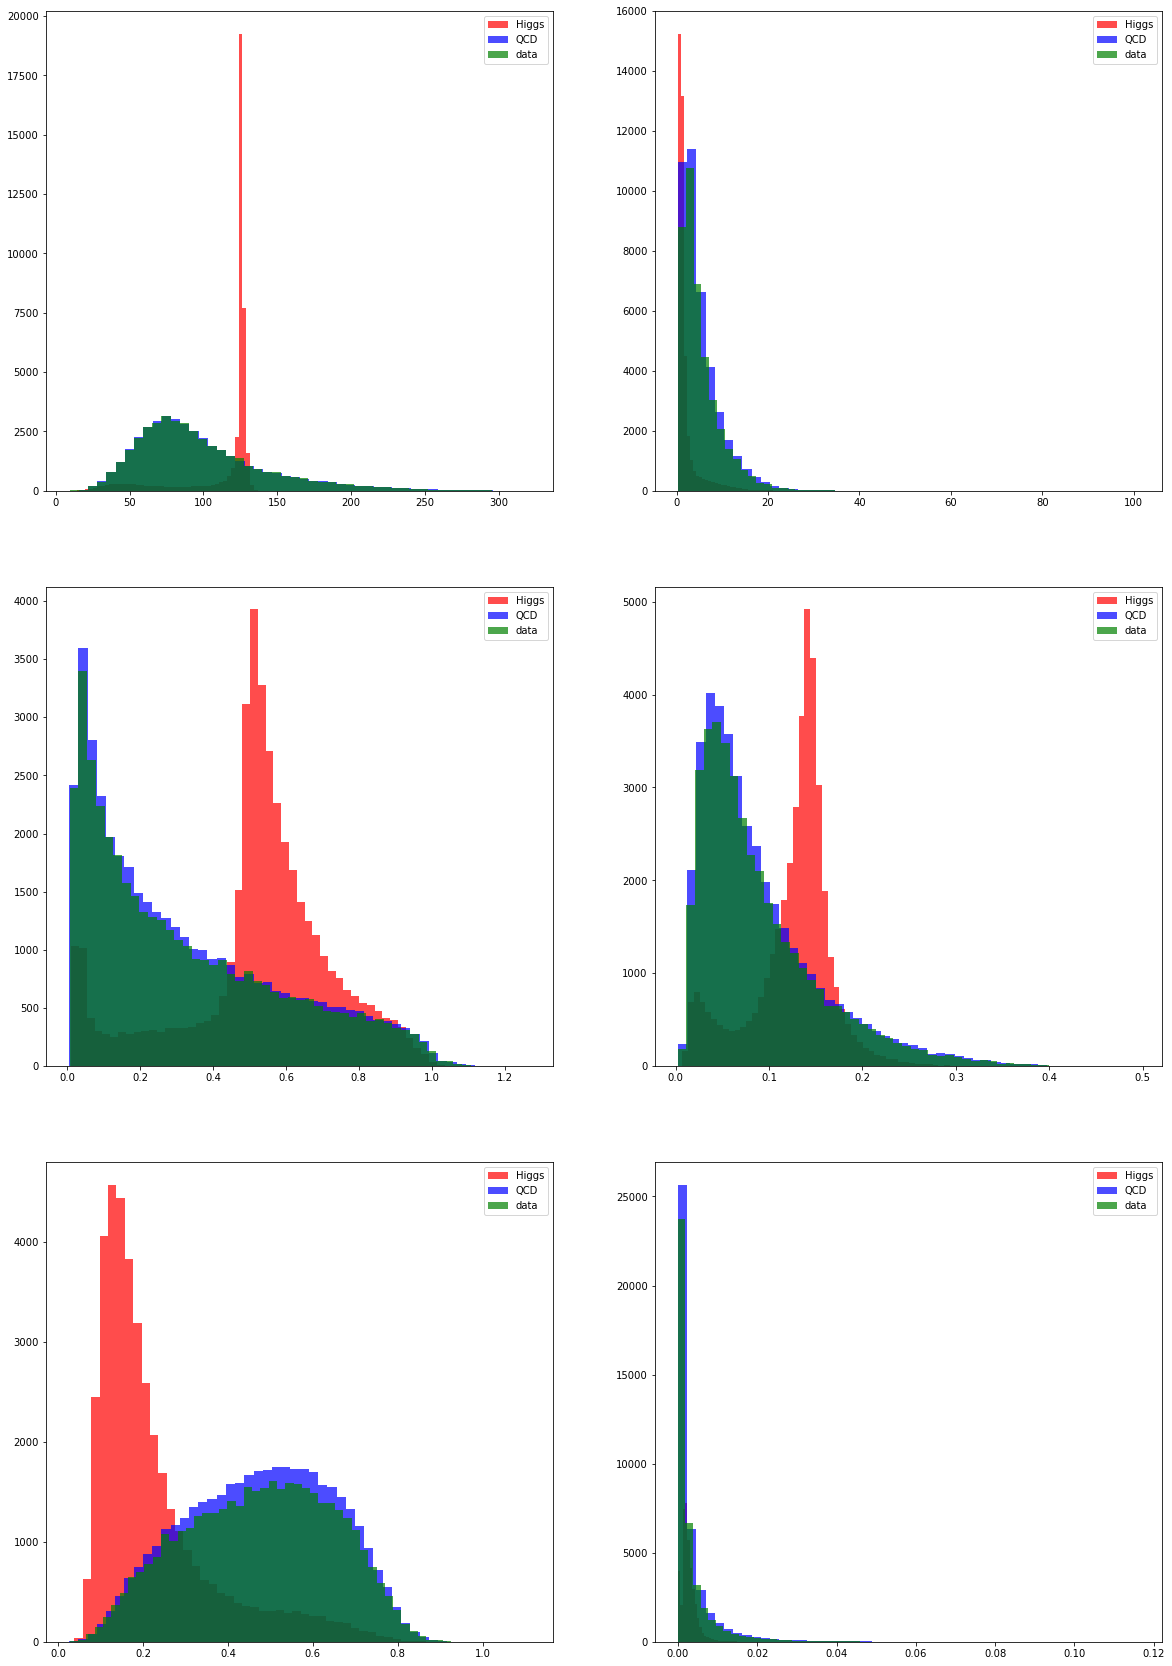

In [21]:
plt.rcParams["figure.figsize"] = (20,30)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = (ax1,ax2,ax3,ax4,ax5,ax6)
features = ['mass','d2','KtDeltaR','ee2','t3','ee3']
for i in range(0,6):
    counts,bins = np.histogram(new_dict[features[i]],bins = 50)
    axes[i].hist(bins[:-1],bins, weights = counts*40344/100000, color = 'red',label = 'Higgs',alpha = 0.7)
    counts,bins = np.histogram(qcd_dict[features[i]],bins = 50)
    axes[i].hist(bins[:-1],bins, weights = counts*40344/100000, color = 'blue',label = 'QCD',alpha = 0.7)
    axes[i].hist(high_lumi[features[i]], color = 'green',label = 'data', bins = 50,alpha = 0.7)
    axes[i].legend()
plt.show()

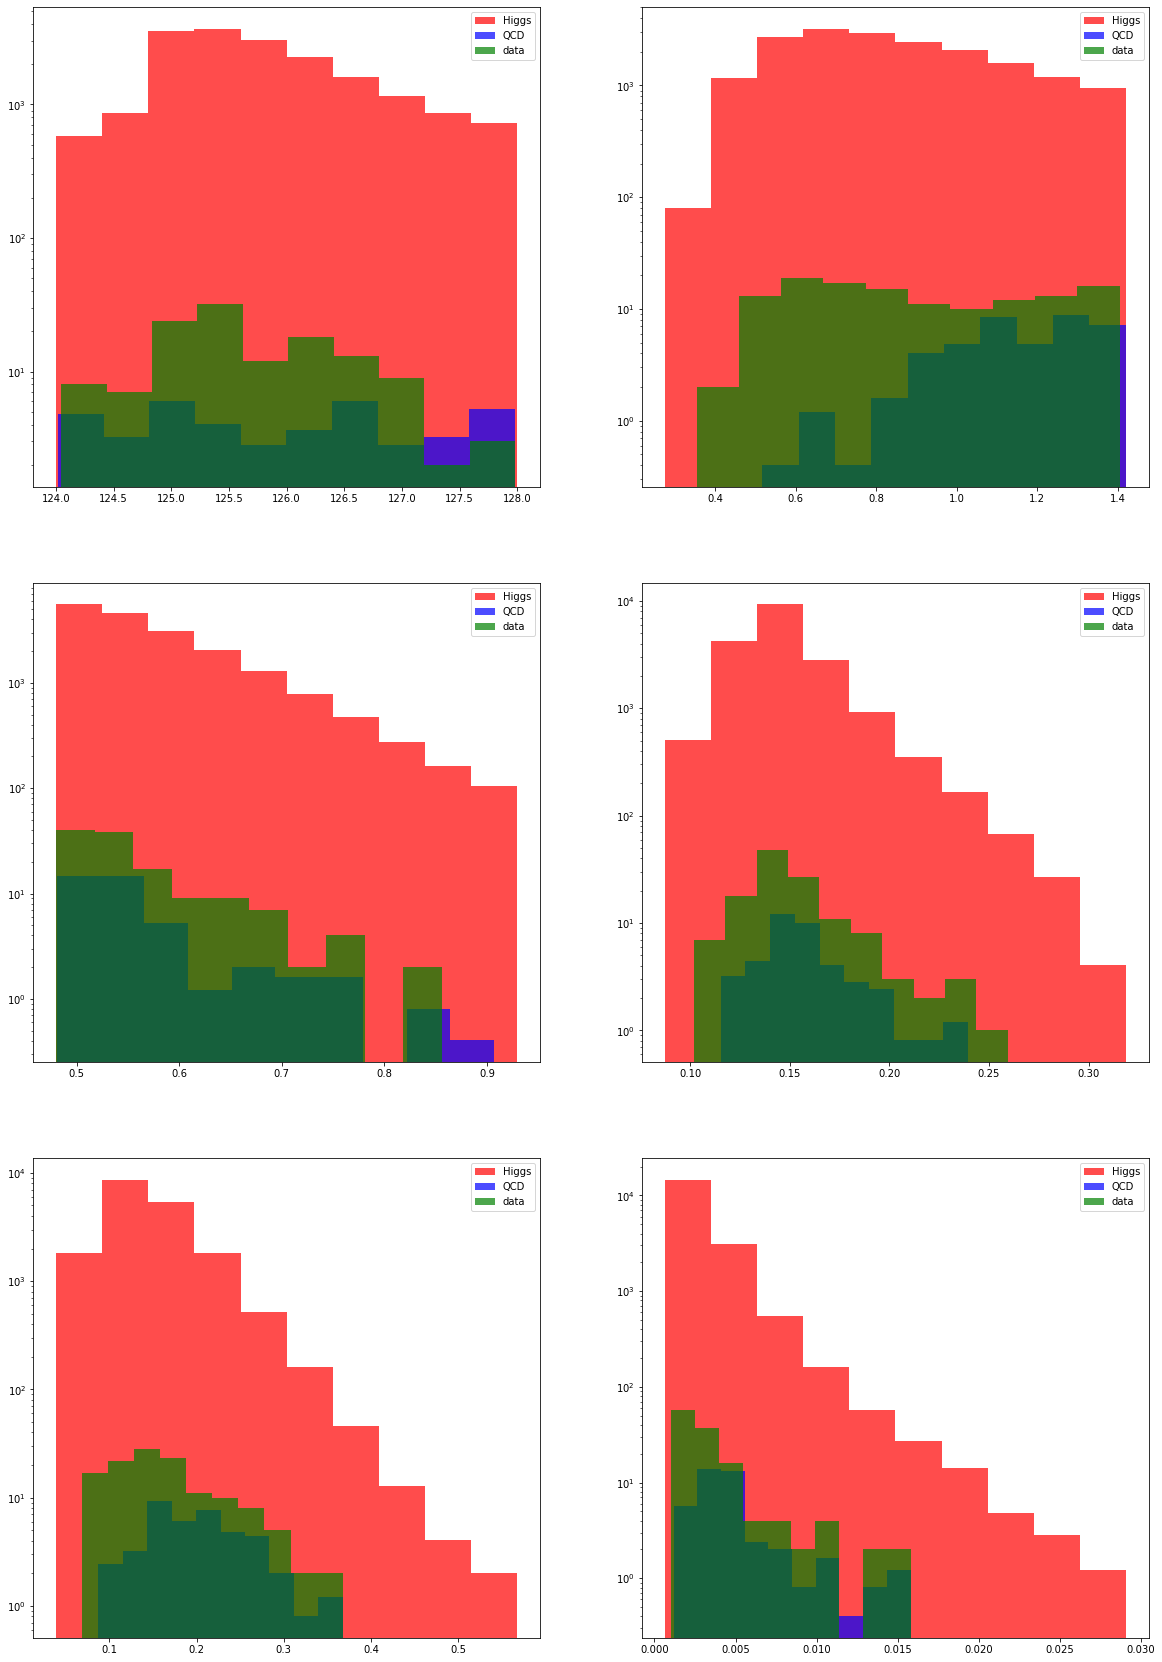

In [22]:
plt.rcParams["figure.figsize"] = (20,30)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = (ax1,ax2,ax3,ax4,ax5,ax6)
features = ['mass','d2','KtDeltaR','ee2','t3','ee3']
cut_higgs = straight_cut(new_dict,['mass','d2','KtDeltaR'],[(124,128),(0,1.42),(0.48,0.93)])
cut_qcd = straight_cut(qcd_dict,['mass','d2','KtDeltaR'],[(124,128),(0,1.42),(0.48,0.93)])
cut_high = straight_cut(high_lumi,['mass','d2','KtDeltaR'],[(124,128),(0,1.42),(0.48,0.93)])
for i in range(0,6):
    counts,bins = np.histogram(cut_higgs[features[i]])
    axes[i].hist(bins[:-1],bins, weights = counts*40344/100000, color = 'red',label = 'Higgs',alpha = 0.7)
    counts,bins = np.histogram(cut_qcd[features[i]])
    axes[i].hist(bins[:-1],bins, weights = counts*40344/100000, color = 'blue',label = 'QCD',alpha = 0.7)
    axes[i].hist(cut_high[features[i]], color = 'green',label = 'data',alpha = 0.7)
    axes[i].legend()
    axes[i].set_yscale('log')
plt.show()

In [23]:
n_qcd = len(cut_qcd)*40344/100000
n_observed = len(cut_high)
sig = np.round(stats.norm.isf(stats.poisson.sf(n_observed,n_qcd)),3)
print('Significance of', n_observed ,'events:',sig,'sigma')

Significance of 128 events: 10.724 sigma


The same cuts made on the simulated data gave a lower significance of $9.2\sigma$

#### 2) Low Luminosity

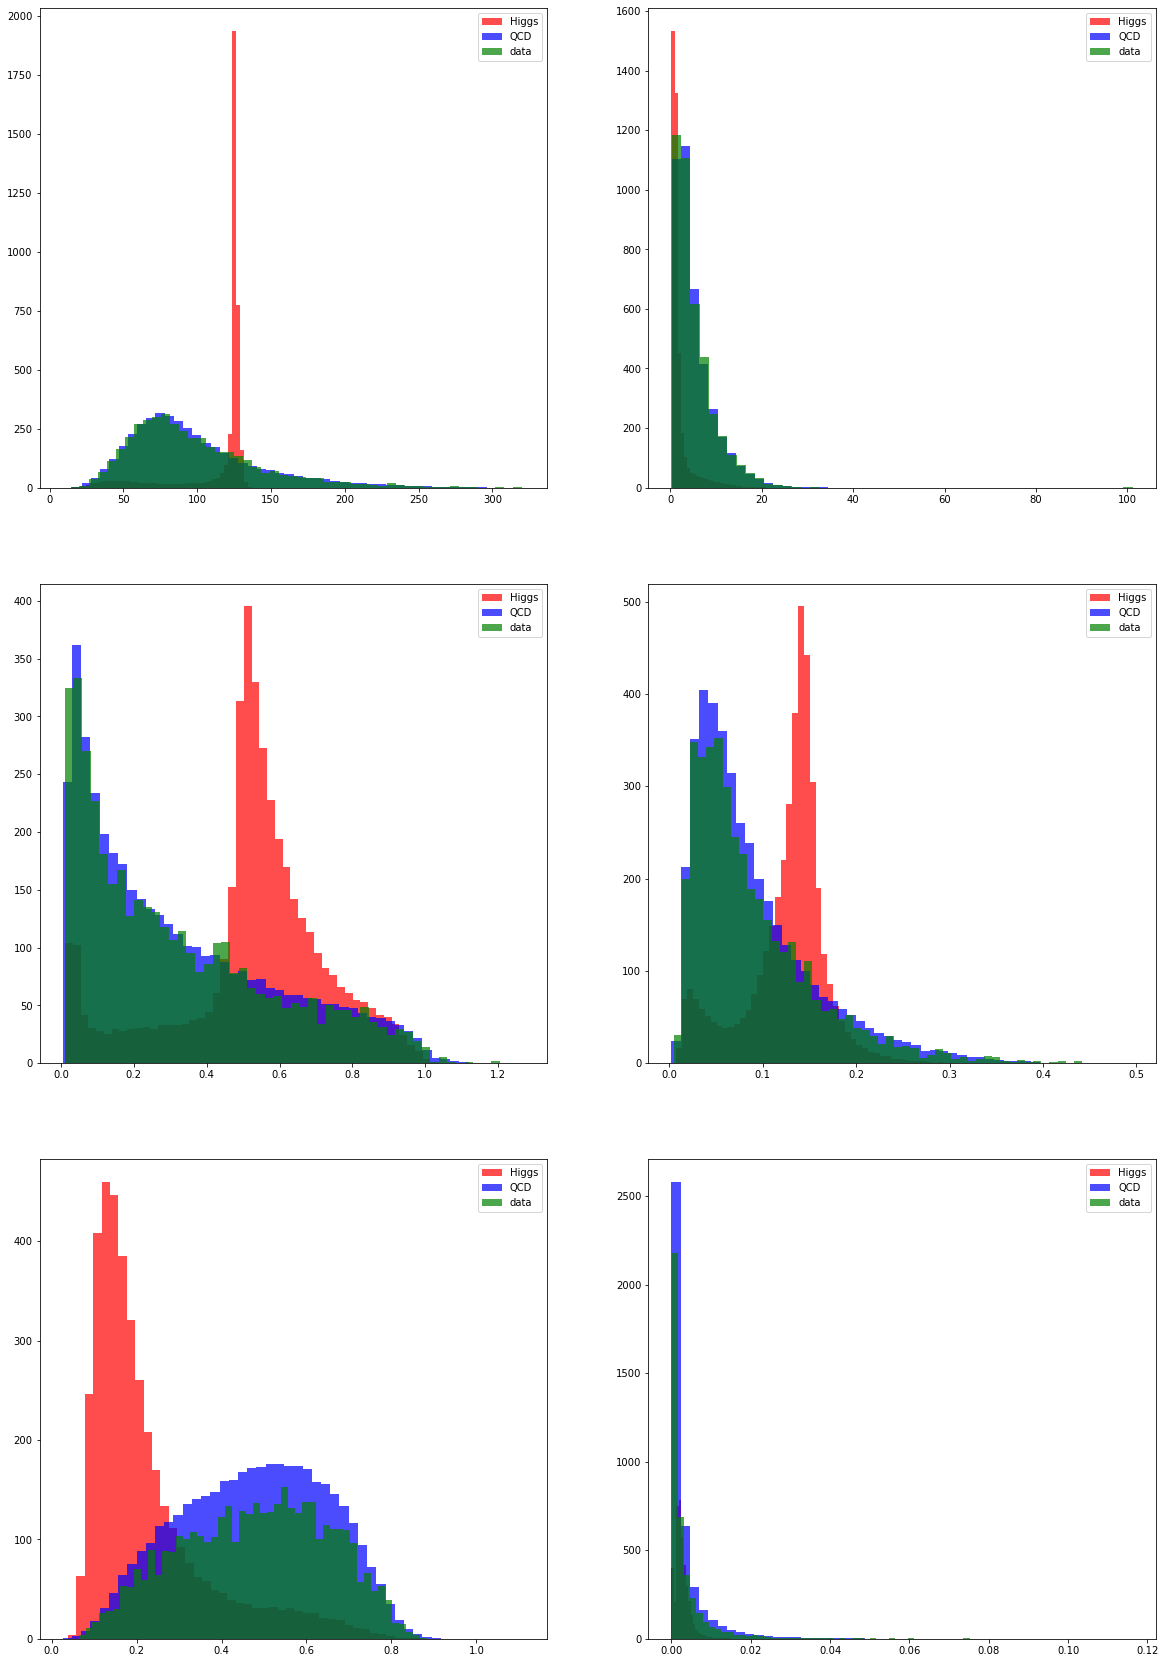

In [24]:
plt.rcParams["figure.figsize"] = (20,30)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = (ax1,ax2,ax3,ax4,ax5,ax6)
features = ['mass','d2','KtDeltaR','ee2','t3','ee3']
for i in range(0,6):
    counts,bins = np.histogram(new_dict[features[i]],bins = 50)
    axes[i].hist(bins[:-1],bins, weights = counts*4060/100000, color = 'red',label = 'Higgs',alpha = 0.7)
    counts,bins = np.histogram(qcd_dict[features[i]],bins = 50)
    axes[i].hist(bins[:-1],bins, weights = counts*4060/100000, color = 'blue',label = 'QCD',alpha = 0.7)
    axes[i].hist(low_lumi[features[i]], color = 'green',label = 'data', bins = 50,alpha = 0.7)
    axes[i].legend()
plt.show()

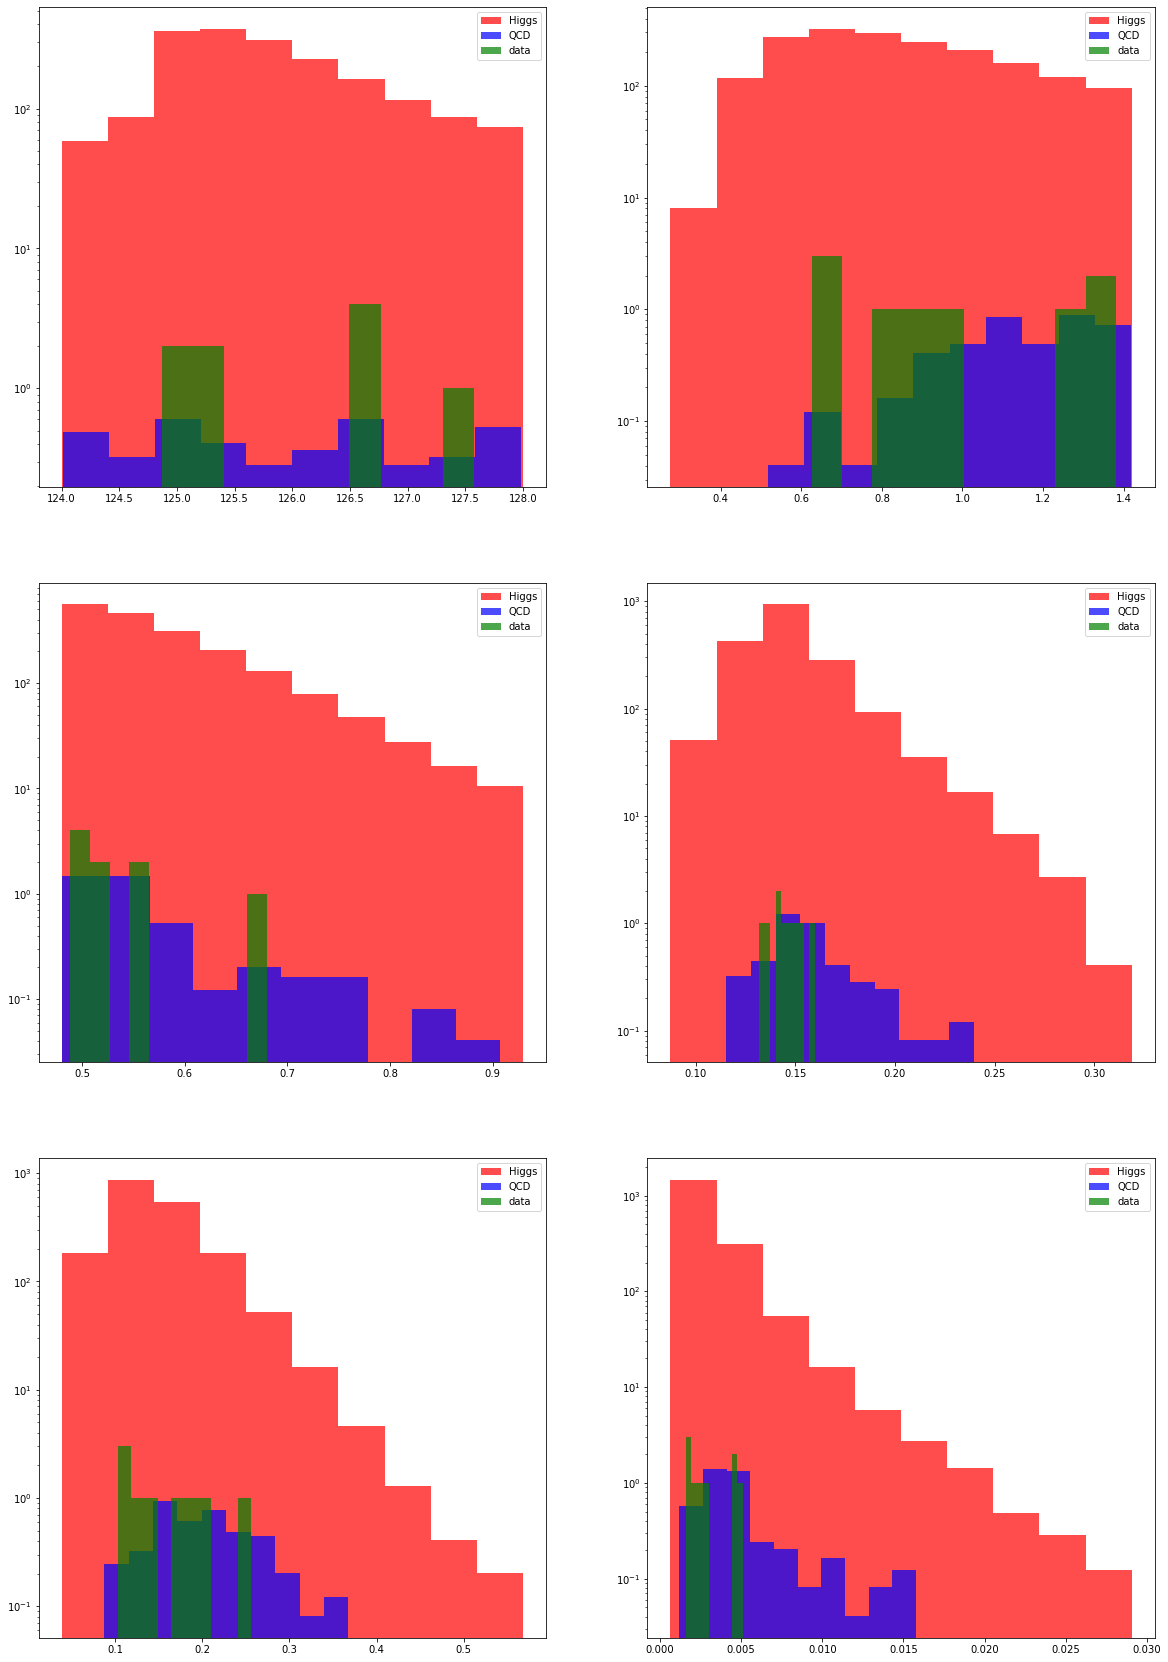

In [25]:
plt.rcParams["figure.figsize"] = (20,30)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = (ax1,ax2,ax3,ax4,ax5,ax6)
features = ['mass','d2','KtDeltaR','ee2','t3','ee3']
cut_low = straight_cut(low_lumi,['mass','d2','KtDeltaR'],[(124,128),(0,1.42),(0.48,0.93)])
for i in range(0,6):
    counts,bins = np.histogram(cut_higgs[features[i]])
    axes[i].hist(bins[:-1],bins, weights = counts*4060/100000, color = 'red',label = 'Higgs',alpha = 0.7)
    counts,bins = np.histogram(cut_qcd[features[i]])
    axes[i].hist(bins[:-1],bins, weights = counts*4060/100000, color = 'blue',label = 'QCD',alpha = 0.7)
    axes[i].hist(cut_low[features[i]], color = 'green',label = 'data',alpha = 0.7)
    axes[i].legend()
    axes[i].set_yscale('log')
plt.show()

In [26]:
n_qcd = len(cut_qcd)*4060/100000
n_observed = len(cut_low)
sig = np.round(stats.norm.isf(stats.poisson.sf(n_observed,n_qcd)),3)
print('Significance of', n_observed ,'events:',sig,'sigma')

Significance of 9 events: 2.273 sigma


#### 3) Confidence Levels of signal yield

95% Upper limit for signal yield low luminosity

$$\sum_{k = 9}^{\infty}P(\mu,k) = 0.95$$
$$P(\mu,k) = \frac{e^{-\mu}\mu^k}{k!}$$
$$\sum_{k = 0}^{9}\frac{e^{-\mu}\mu^k}{k!} = 0.05$$
$$\mu = 15.71$$

In [3]:
print('With a true signal of 15.71, the probability seeing something stronger than 9 events is:',np.round(stats.poisson.sf(9,15.71),4))

With a true signal of 15.71, the probability seeing something stronger than 9 events is: 0.9501


This means that 95% of the time would see more than 9 events if there were a true signal strength of 15.71 events.

For the low luminosity data we expected to see 4.22 events, since the data is poisson distributed we will round up to 5 events in order to get more than 95%

$$\sum_{k = 5}^{\infty}P(\mu,k) = 0.95$$
$$P(\mu,k) = \frac{e^{-\mu}\mu^k}{k!}$$
$$\sum_{k = 0}^{5}\frac{e^{-\mu}\mu^k}{k!} = 0.05$$
$$\mu = 10.51$$

In [4]:
prob = 0
mu = 128
while prob>0.05:
    prob = stats.poisson.cdf(128,mu)
    mu+=0.02
print(mu,prob)

128 0


In [5]:
print('With a true signal of 10.513, the probability seeing something stronger than 4.22 events is:',np.round(stats.poisson.sf(4.22,10.513),4))

With a true signal of 10.513, the probability seeing something stronger than 4.22 events is: 0.9791


The expected upper limit of 10.513 is lower than the observed upper limit of 15.71, this means that while there were more observed events than expected, we cannot say with 95% certainty that there was no signal present, but we cannot also say with certainty that we have seen a signal.